<a href="https://colab.research.google.com/github/KemasRaihan/Sentiment-Analysis-Of-Social-Media-Posts-Of-Phones-Using-Hybrid-Neural-Networks/blob/main/Customer_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [4]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
# % matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
#For Qualitative Analysis
from itertools import groupby
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
# For fixing imbalanced data
from collections import Counter
from imblearn.over_sampling import SMOTE

In [7]:
# For Text Preprocessing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
nltk.download('words')
#nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
import string

from sklearn.feature_extraction.text import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm

import csv
import matplotlib.pyplot as plt
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [9]:
# For building the neural networks
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, SpatialDropout1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [10]:
# For evaluation
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

# Other Prequisites

In [11]:
# Number of Epochs for each model to train
EPOCHS = 20

In [12]:
# Directory path
dirpath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/'

In [ ]:
# Read GloVe Embedding

# Load GloVe word embeddings and create an Embeddings Dictionary
filepath = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/a2_glove.6B.100d.txt'

embeddings_index = dict()
f = open(filepath)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Define classes
# There are 3 classes: negative, neutral and postive
num_of_classes = 3

**Raw Dataset**

PromptCloud extracted 400 thousand reviews of unlocked mobile phones sold on Amazon.com to find out insights with respect to reviews, ratings, price and their relationships (https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)

In [ ]:
# Import Raw Dataset
filepath = dirpath + 'Amazon_Unlocked_Mobile.csv'

# Control number of rows to read from csv file
nrows = 1000

df = pd.read_csv(filepath,nrows=nrows, encoding = 'latin')

**Display Graphs**

In [ ]:
def display_graphs(history):
  fig, ax = plt.subplots(1, 2, figsize=(17, 5))
  ax[0].plot(history.history['acc'])
  ax[0].plot(history.history['val_acc'])

  ax[0].set_title('Model Accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epochs')
  ax[0].legend(['train','test'], loc='upper left')

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])

  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('Epochs')
  ax[1].legend(['train','test'], loc='upper left')
  plt.show()


# Quantitative Analysis

In [ ]:
df.shape

(1000, 6)

In [ ]:
df.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
5,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,1,I already had a phone with problems... I know ...,1.0
6,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,The charging port was loose. I got that solder...,0.0
7,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,2,"Phone looks good but wouldn't stay charged, ha...",0.0
8,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I originally was using the Samsung S2 Galaxy f...,0.0
9,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,3,It's battery life is great. It's very responsi...,0.0


**Drop NA Rows**

In [ ]:
df.isnull().any()

Product Name    False
Brand Name       True
Price           False
Rating          False
Reviews         False
Review Votes     True
dtype: bool

In [ ]:
df = df.dropna()

**Number Of Ratings Of Each Sentiment**

In [ ]:
ratings = df['Rating'].values.tolist()

In [ ]:
ratings[:5]

[5, 4, 5, 4, 4]

In [ ]:
frequency = []

for i in range(1,6):
  frequency.append(ratings.count(i))

In [ ]:
print(frequency)

[136, 57, 42, 61, 239]


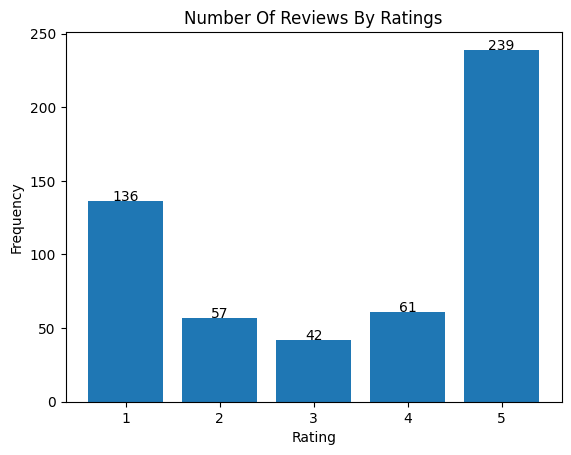

In [ ]:
labels = [1,2,3,4,5]

 # the label locations
x = np.arange(len(labels)) + 1

fig, ax = plt.subplots()

# the width of the bars
width = 0.8
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Number Of Reviews By Ratings')
ax.set_xticks(labels)
ax.set_xticklabels(labels)

pps = ax.bar(x, frequency, width, label='population')
for p in pps:
  height = p.get_height()
  ax.text(x=p.get_x() + p.get_width() / 2, y=height+.2,
          s="{}".format(height),
          ha='center')
plt.show()

**Brand**

In [ ]:
brands = sorted(df['Brand Name'].unique())

print(brands)

['Cedar Tree Technologies', 'Elephone', 'HTM', 'Huawei', 'Indigi', 'JUNING', 'Jethro', 'Lenovo', 'Nokia', 'OtterBox', 'Phone Baby', 'Plum', 'Samsung', 'e passion']


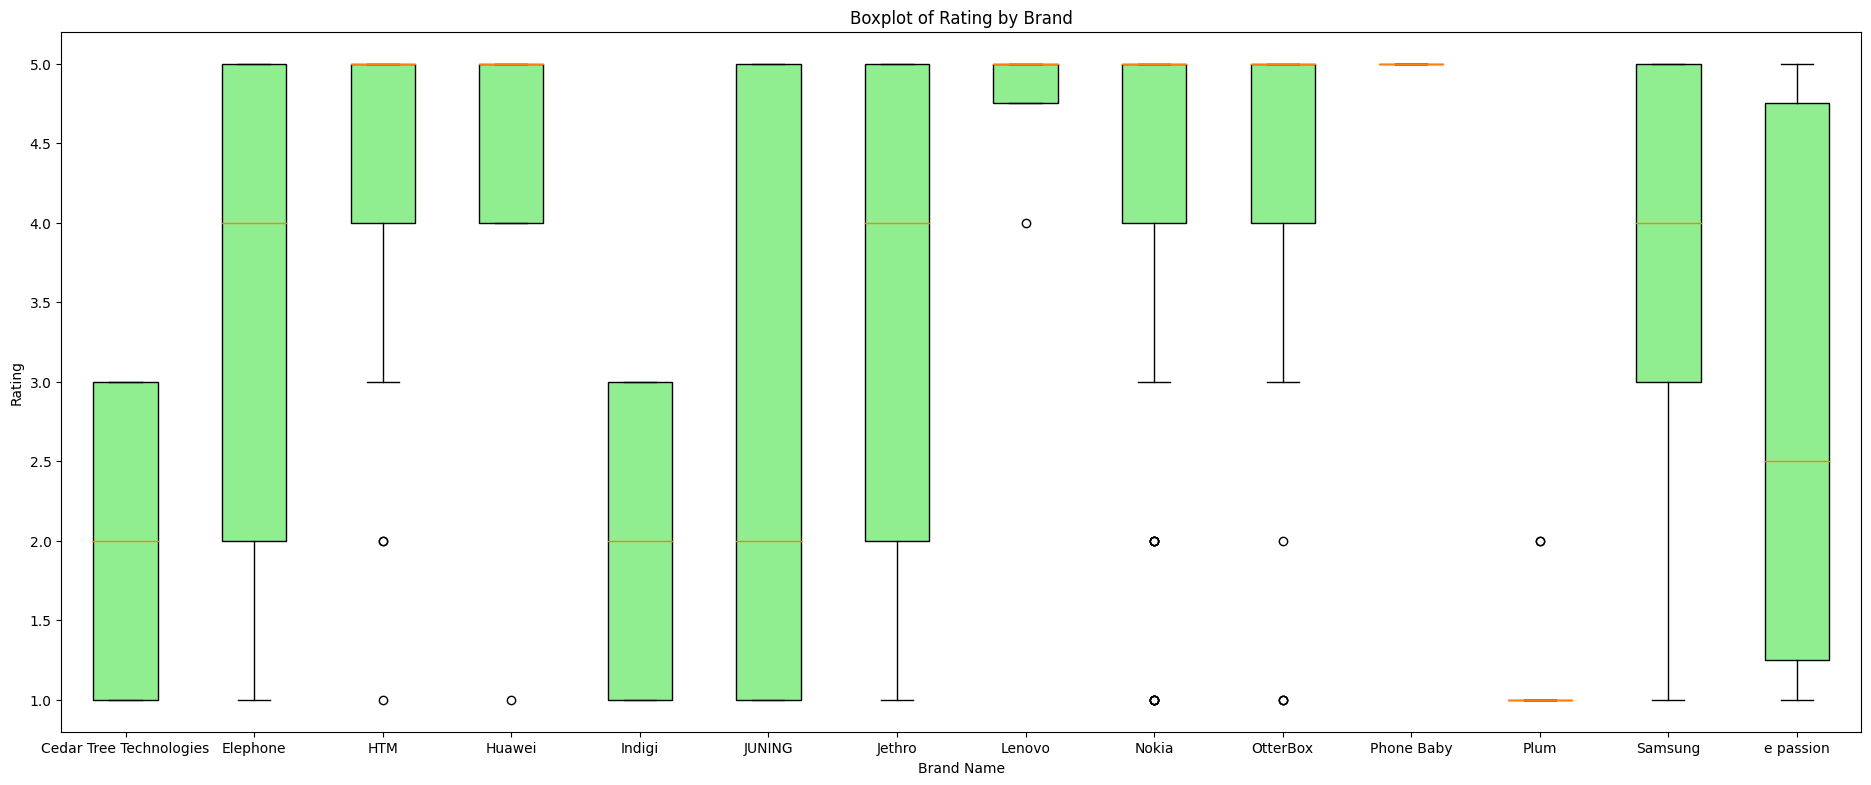

In [ ]:
# Groupby by brand name
df_brands = df.groupby("Brand Name")

# initialise array to store each boxplot data
data = []

for brand in brands:
  # Group dataframe by the brand
  dfb = df_brands.get_group(brand)

  ratings = np.array(dfb['Rating'])

  data.append(ratings)

fig = plt.figure(figsize =(18, 7))

# Creating axes instance
ax = fig.add_axes([1, 1, 1, 1])

ax.set_title('Boxplot of Rating by Brand')
ax.set_ylabel('Rating')
ax.set_xlabel('Brand Name')
ax.set_xticklabels(brands)

# Creating plot
bp = ax.boxplot(data,
           patch_artist = True,
           boxprops = dict(facecolor = "lightgreen"))

# show plot
plt.show()


**Price**

In [ ]:
ratings = sorted(df['Rating'].unique())

print(ratings)

[1, 2, 3, 4, 5]


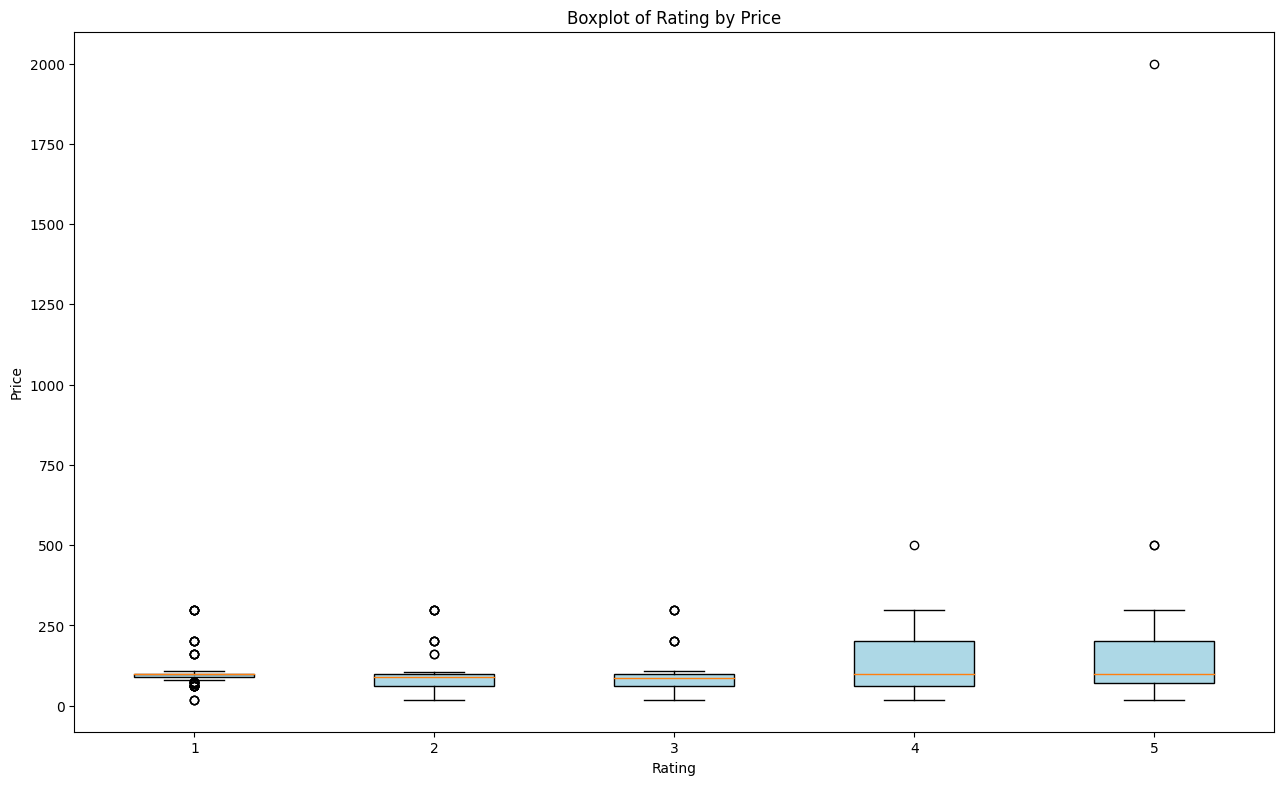

In [ ]:
# Groupby by ratings
df_ratings = df.groupby("Rating")

# initialise array to store each boxplot data
data = []

for rating in ratings:
  # Group dataframe by the rating
  dfr = df_ratings.get_group(rating)

  prices = np.array(dfr['Price'])

  data.append(prices)

fig = plt.figure(figsize =(12, 7))

# Creating axes instance
ax = fig.add_axes([1, 1, 1, 1])

ax.set_title('Boxplot of Rating by Price')
ax.set_ylabel('Price')
ax.set_xlabel('Rating')
ax.set_xticklabels(ratings)

# Creating plot
bp = ax.boxplot(data,
           patch_artist = True,
           boxprops = dict(facecolor = "lightblue"))
# show plot
plt.show()

# Reduce Classes

In [ ]:
sentiments = []
ratings = df['Rating']

for rating in ratings:
  # if rating is 1 or 2 (negative) append 0 to sentiments array
  if rating < 3:
    sentiments.append(0)
  # if rating is 3 (neutral), append 1 to sentiments array
  elif rating == 3:
    sentiments.append(1)
  # if rating is 4 or 5 (positive), append 2 to sentiments array
  else:
    sentiments.append(2)


In [ ]:
frequency = []

for i in range(3):
  frequency.append(sentiments.count(i))

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']

 # the label locations
x = np.arange(len(labels)) + 1

fig, ax = plt.subplots()

# the width of the bars
width = 0.8
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title('Number Of Reviews By Ratings')
ax.set_xticks(x)
ax.set_xticklabels(labels)

pps = ax.bar(x, frequency, width, label='population', color='red')
for p in pps:
  height = p.get_height()
  ax.text(x=p.get_x() + p.get_width() / 2, y=height+.2,
          s="{}".format(height),
          ha='center')
plt.show()

In [ ]:
# Append new column to original dataframe
df = df.assign(Sentiment=sentiments)

In [ ]:
# Remove original Rating column
df = df.drop('Rating',axis=1)

In [ ]:
df.tail()

# Preprocessing Text

In [ ]:
reviews = df['Reviews']

In [ ]:
reviews.head()

In [ ]:
def preprocess_text(review):
    # Remove stopwords 'n punctuation
    sw = stopwords.words('english')
    review = review.lower() # Convert to lowercase
    review = re.sub(r'[^\x00-\x7F]+',' ', review) # Remove words with non-ASCII characters
    words = review.split()
    words = [word for word in words if word not in set(stopwords.words('english'))] # Remove stop words
    review = " ".join(words)
    return review

In [ ]:
reviews = reviews.apply(preprocess_text)

# Qualitative Analysis

In [ ]:
# Creating an object using groupby
df_sentiments = df.groupby('Sentiment')

In [ ]:
def generate_wordcloud(sentiment, ax, title, cm):

    # Group dataframe by the sentiment
    df = df_sentiments.get_group(sentiment)

    # Creating the text variable
    text = " ".join(review for review in df['Reviews'])

    # Creating word cloud with text as argument in .generate() method
    wordcloud = WordCloud(collocations=False, background_color='white', colormap=cm).generate(text)

    # Display the generated Word Cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)
    # ax.show()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18,6))
fig.suptitle('Word Cloud For Each Sentiment', fontsize=20)

# Generate wordcloud of negative reviews
generate_wordcloud(0, axes[0],  'negative', 'Reds')

# Generate wordcloud of neutral reviews
generate_wordcloud(1, axes[1],  'neutral', 'Purples')

# Generate wordcloud of positive reviews
generate_wordcloud(2, axes[2],  'positive', 'Greens')

plt.show()

# Tokenize

In [ ]:
def tokenize(review):
  # Convert text to sequences
  encoded_review = t.texts_to_sequences(review)

  # Pad reviews
  padded_review = pad_sequences(encoded_review, maxlen=max_length, padding='post')

  return padded_review

In [ ]:
# Find the length of longest review
max_length = reviews.apply(lambda x: len(x.split())).max()
t = Tokenizer()
t.fit_on_texts(reviews)

vocab_size = len(t.word_index) + 1

# Convert text to sequences
padded_reviews = tokenize(reviews)

In [ ]:
# Map each unique word index with its GloVe vector

embedding_dim = 100

# Initialize an empty matrix with zeros, where the number of rows is determined by the vocabulary size (vocab_size),
# and the number of columns is set to 100, matching the dimensionality of the GloVe word embeddings.
embedding_matrix = np.zeros((vocab_size, 100))

# Iterate through each word in the tokenizer's word index
for word, i in t.word_index.items():
  # Retrieve the GloVe word embedding vector for the current word
    embedding_vector = embeddings_index.get(word)
    # Check if the word has a corresponding embedding in the GloVe model
    if embedding_vector is not None:
      # If an embedding exists, update the corresponding row in the embedding matrix
        # with the GloVe word embedding vector for the current word.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix[:5])

# Define Training, Validation and Testing Dataset

In [ ]:
one_hot_encoded_Y = pd.get_dummies(sentiments).values

In [ ]:
one_hot_encoded_Y.shape

In [ ]:
reviews.shape

In [ ]:
# Firstly split them into the training dataset and the rest as remaining dataset for validation and testing
train_reviews, remain_reviews, y_train, y_rem = train_test_split(reviews, one_hot_encoded_Y, train_size=0.8, random_state=42)

# Split the remaining dataset for validation and testing
valid_reviews, test_reviews, y_valid, y_test = train_test_split(remain_reviews, y_rem, train_size=0.5)

In [ ]:
print(train_reviews[:5])

In [ ]:
train_reviews_padded = tokenize(train_reviews)

valid_reviews_padded = tokenize(valid_reviews)

In [ ]:
train_reviews_padded.shape

In [41]:
y_train.shape

(800, 3)

# Simple Neural Network (SNN)

In [42]:
SNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length , trainable=False),
    Flatten(),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for Simple Neural Network model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
SNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

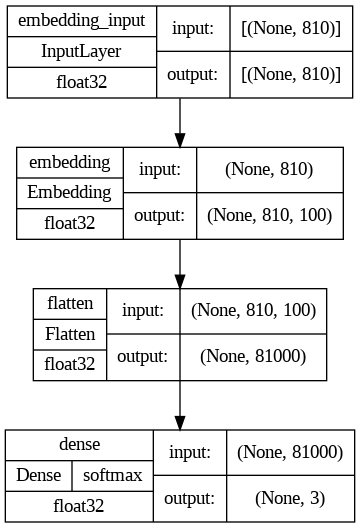

In [43]:
plot_model(
  SNN,
  show_shapes = True,
  show_dtype = True,
  show_layer_activations = True
)

In [44]:
SNN_history = SNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
25/25 [==============================] - 2s 11ms/step - loss: 0.9248 - acc: 0.6475 - val_loss: 0.8865 - val_acc: 0.6900
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.7766 - acc: 0.7625 - val_loss: 0.8546 - val_acc: 0.6700
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.7002 - acc: 0.7900 - val_loss: 0.8001 - val_acc: 0.6900
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.6440 - acc: 0.8062 - val_loss: 0.7715 - val_acc: 0.7300
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5987 - acc: 0.8087 - val_loss: 0.7300 - val_acc: 0.7400
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5634 - acc: 0.8338 - val_loss: 0.7199 - val_acc: 0.7600
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.5309 - acc: 0.8413 - val_loss: 0.7094 - val_acc: 0.7600
Epoch 8/20
25/25 [==============================] - 0s 5ms/step - loss: 0.5047 - acc: 0.8

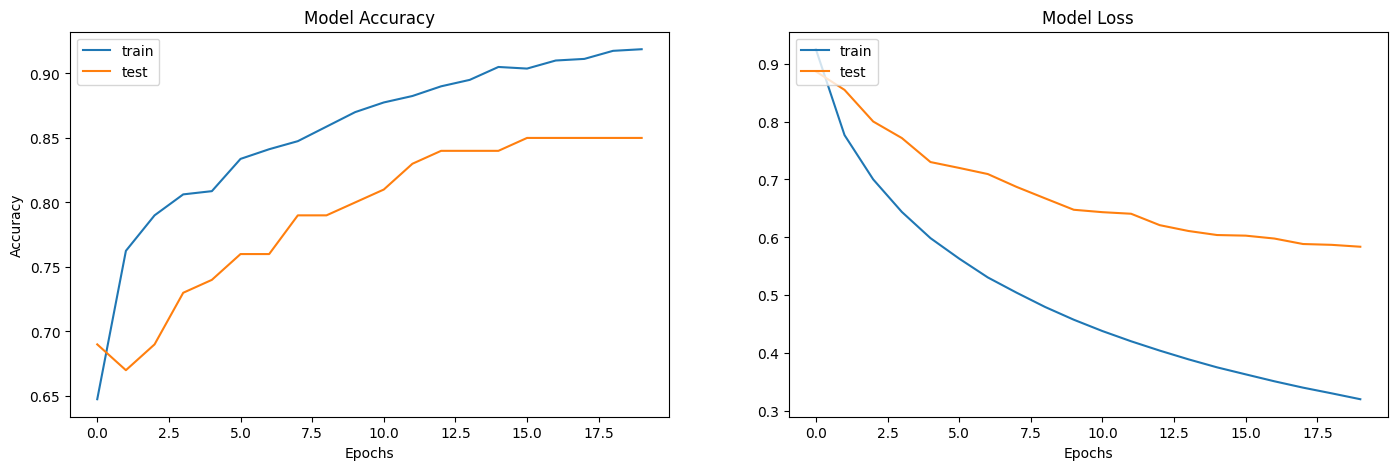

In [45]:
display_graphs(SNN_history)

In [46]:
# Define file path to save/load SNN model
filename = 'SNN_rating_predictor.keras'
filepath_SNN = dirpath + '/models/' + filename

In [47]:
# save SNN model
keras.saving.save_model(SNN, filepath_SNN)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code//models/SNN_rating_predictor.keras'

# Convolutional Neural Network (CNN)

In [ ]:
CNN = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for CNN model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
plot_model(
  CNN,
  show_shapes = True,
  show_dtype = True,
  show_layer_activations = True
)

In [ ]:
CNN_history = CNN.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

In [ ]:
display_graphs(CNN.history)

In [ ]:
filename = 'CNN_rating_predictor.keras'

# Define file path to save/load CNN model
filepath_CNN = dirpath + '/models/' + filename

In [ ]:
# save CNN model
keras.saving.save_model(CNN, filepath_CNN)

# Long-Short Term Memory (LSTM)

In [ ]:
# Build an LSTM model
LSTM = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for LSTM model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

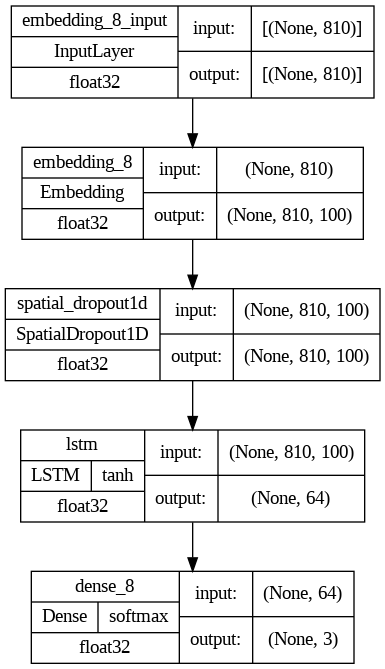

In [ ]:
plot_model(
    LSTM,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
# Train the model
LSTM_history = LSTM.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
25/25 [==============================] - 36s 1s/step - loss: 1.0819 - acc: 0.6137 - val_loss: 1.0697 - val_acc: 0.5400
Epoch 2/20
25/25 [==============================] - 25s 975ms/step - loss: 1.0158 - acc: 0.6225 - val_loss: 0.9493 - val_acc: 0.5400
Epoch 3/20
25/25 [==============================] - 26s 1s/step - loss: 0.8617 - acc: 0.6237 - val_loss: 0.9577 - val_acc: 0.5400
Epoch 4/20
25/25 [==============================] - 25s 1s/step - loss: 0.8559 - acc: 0.6237 - val_loss: 0.9421 - val_acc: 0.5400
Epoch 5/20
25/25 [==============================] - 25s 1s/step - loss: 0.8584 - acc: 0.6237 - val_loss: 0.9348 - val_acc: 0.5400
Epoch 6/20
25/25 [==============================] - 24s 931ms/step - loss: 0.8584 - acc: 0.6237 - val_loss: 0.9280 - val_acc: 0.5400
Epoch 7/20
25/25 [==============================] - 27s 1s/step - loss: 0.8588 - acc: 0.6237 - val_loss: 0.9397 - val_acc: 0.5400
Epoch 8/20
25/25 [==============================] - 25s 1s/step - loss: 0.8581 - acc

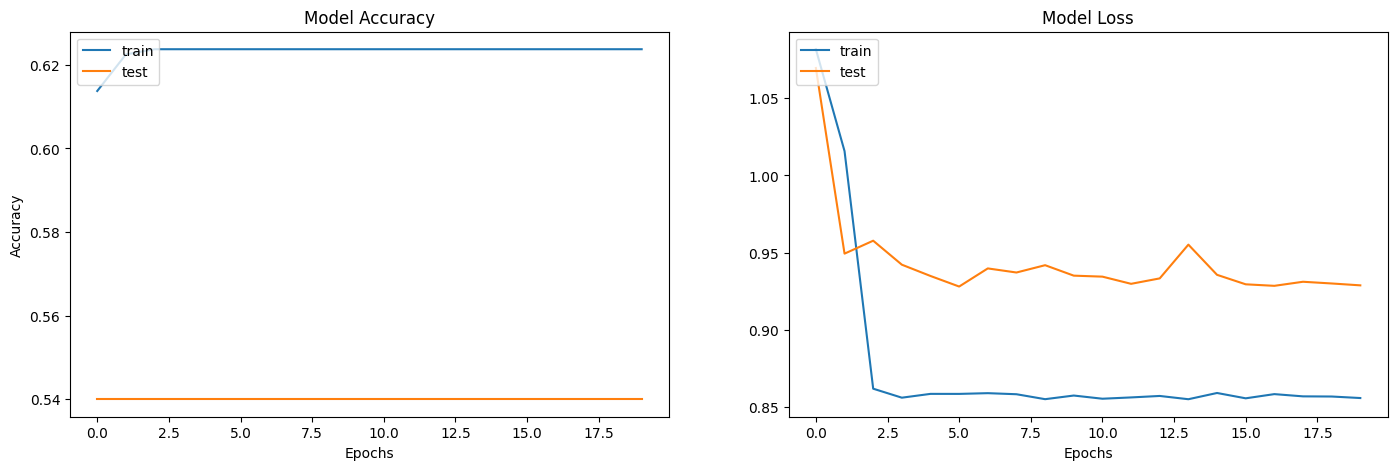

In [ ]:
display_graphs(LSTM.history)

In [ ]:
filename = 'LSTM_rating_predictor.keras'

# Define file path to save/load LSTM model
filepath_LSTM = dirpath + '/folder/' + filename

In [ ]:
# save LSTM model
keras.saving.save_model(LSTM, filepath_LSTM)

# CNN + LSTM

In [ ]:
CNN_LSTM= Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(64, kernel_size=5, activation = "relu"),
    MaxPooling1D(pool_size=4),
    SpatialDropout1D(0.2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(num_of_classes, activation='softmax')
])

# Define optimiser for Hybrid model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

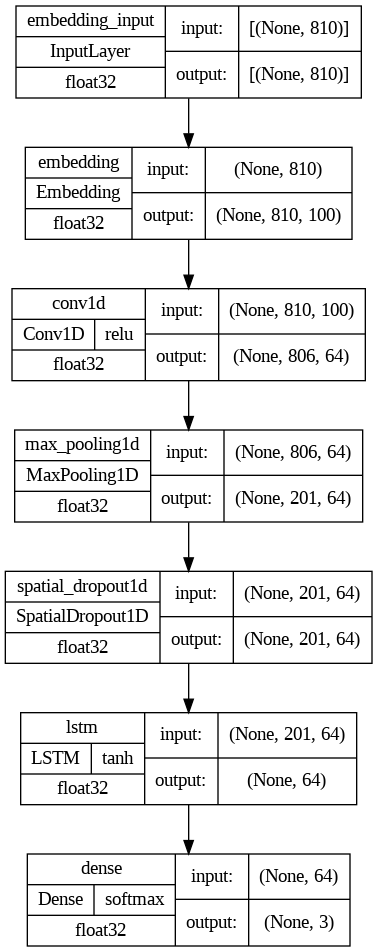

In [ ]:
plot_model(
    CNN_LSTM,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
# Train the model
CNN_LSTM_history = CNN_LSTM.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
25/25 [==============================] - 19s 505ms/step - loss: 1.0316 - acc: 0.5825 - val_loss: 0.9824 - val_acc: 0.5400
Epoch 2/20
25/25 [==============================] - 11s 453ms/step - loss: 0.8860 - acc: 0.6237 - val_loss: 0.9569 - val_acc: 0.5400
Epoch 3/20
25/25 [==============================] - 12s 473ms/step - loss: 0.8575 - acc: 0.6237 - val_loss: 0.9609 - val_acc: 0.5400
Epoch 4/20
25/25 [==============================] - 12s 495ms/step - loss: 0.8560 - acc: 0.6237 - val_loss: 0.9616 - val_acc: 0.5400
Epoch 5/20
25/25 [==============================] - 12s 480ms/step - loss: 0.8564 - acc: 0.6237 - val_loss: 0.9710 - val_acc: 0.5400
Epoch 6/20
25/25 [==============================] - 14s 547ms/step - loss: 0.8616 - acc: 0.6237 - val_loss: 0.9771 - val_acc: 0.5400
Epoch 7/20
25/25 [==============================] - 12s 487ms/step - loss: 0.8558 - acc: 0.6237 - val_loss: 0.9599 - val_acc: 0.5400
Epoch 8/20
25/25 [==============================] - 11s 451ms/step - 

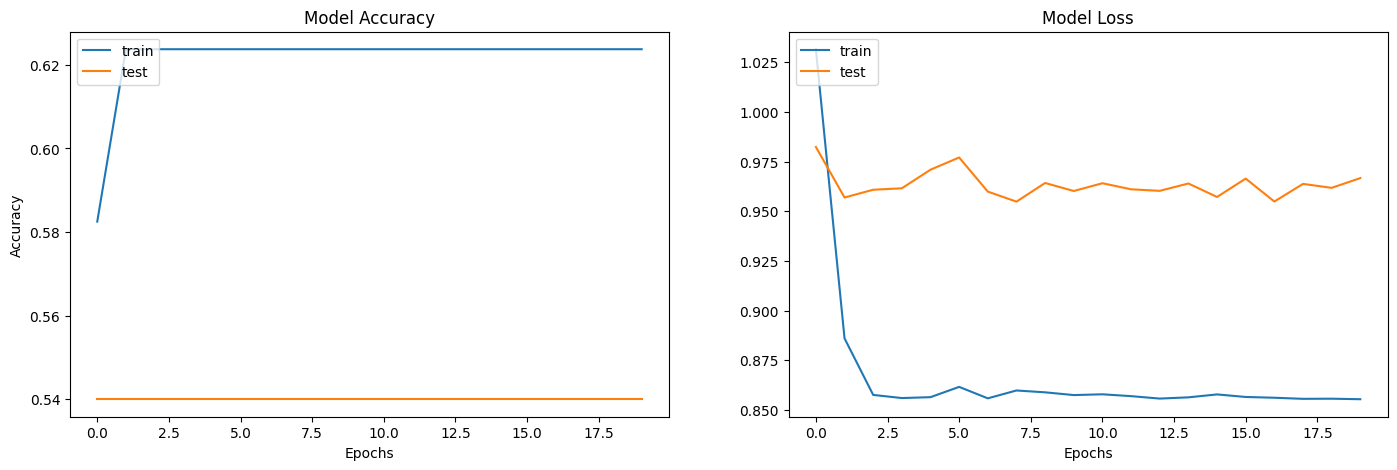

In [ ]:
display_graphs(CNN_LSTM.history)

In [ ]:
# Define file path to save/load CNN + LSTM model
filepath_CNN_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_LSTM_rating_predictor.keras'

In [ ]:
# save CNN + LSTM model
keras.saving.save_model(CNN_LSTM, filepath_CNN_LSTM)

# CNN + Dense

In [ ]:
CNN_Dense = Sequential([
  Embedding(vocab_size, embedding_dim, input_length=max_length),
  Conv1D(64, 5, activation='relu'),
  MaxPooling1D(pool_size=4),
  Dense(100, activation='relu'),
  Flatten(),
  Dense(num_of_classes, activation='softmax')
])

# Define optimiser for CNN + Dense model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_Dense.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

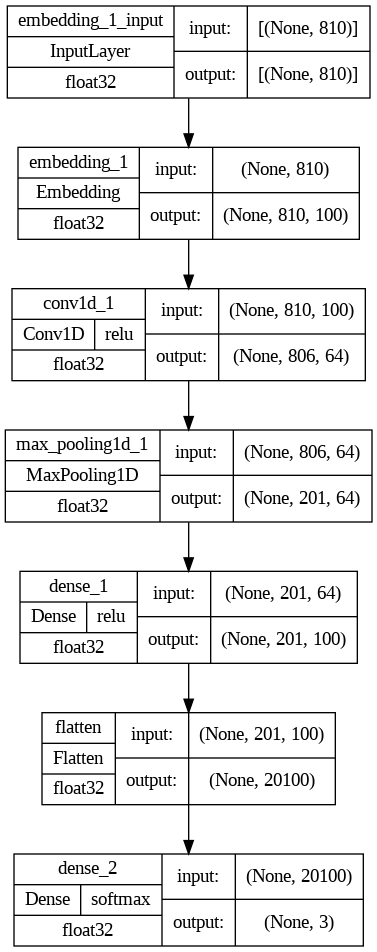

In [ ]:
plot_model(
    CNN_Dense,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
# Train the CNN + Dense model
CNN_Dense_history = CNN_Dense.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
25/25 [==============================] - 3s 94ms/step - loss: 0.8872 - acc: 0.6175 - val_loss: 0.9746 - val_acc: 0.5400
Epoch 2/20
25/25 [==============================] - 2s 78ms/step - loss: 0.8528 - acc: 0.6237 - val_loss: 0.9535 - val_acc: 0.5400
Epoch 3/20
25/25 [==============================] - 2s 70ms/step - loss: 0.8475 - acc: 0.6237 - val_loss: 0.9179 - val_acc: 0.5400
Epoch 4/20
25/25 [==============================] - 2s 68ms/step - loss: 0.8396 - acc: 0.6237 - val_loss: 0.9140 - val_acc: 0.5400
Epoch 5/20
25/25 [==============================] - 2s 70ms/step - loss: 0.8240 - acc: 0.6237 - val_loss: 0.9245 - val_acc: 0.5400
Epoch 6/20
25/25 [==============================] - 3s 116ms/step - loss: 0.8165 - acc: 0.6250 - val_loss: 0.9085 - val_acc: 0.5400
Epoch 7/20
25/25 [==============================] - 2s 74ms/step - loss: 0.8002 - acc: 0.6450 - val_loss: 0.8851 - val_acc: 0.5400
Epoch 8/20
25/25 [==============================] - 2s 72ms/step - loss: 0.7856 - 

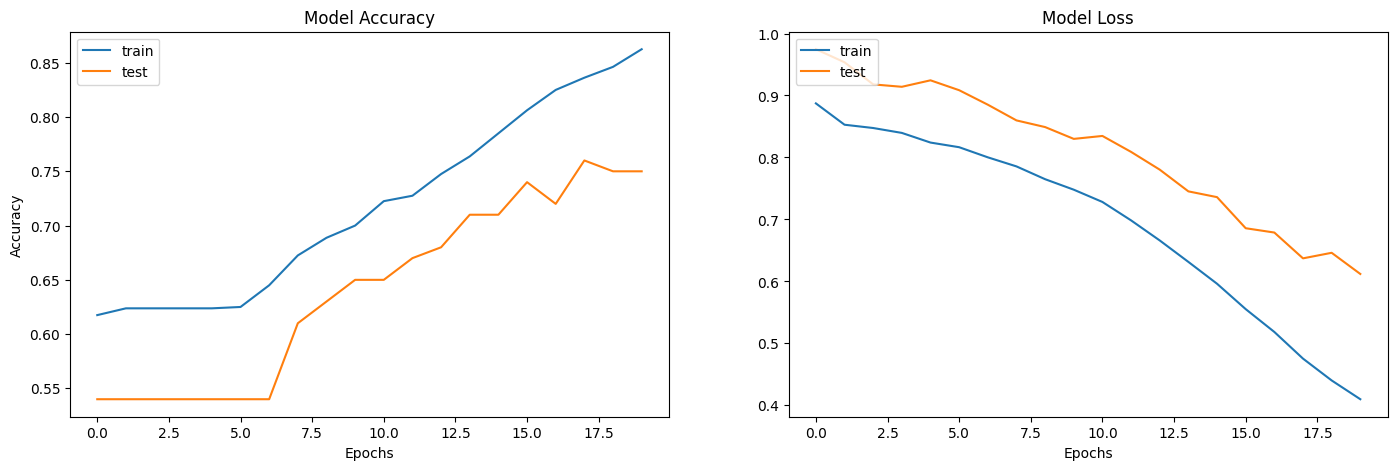

In [ ]:
display_graphs(CNN_Dense.history)

In [ ]:
# Define file path to save/load CNN + Dense model
filepath_CNN_Dense= '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_Dense_rating_predictor.keras'

In [ ]:
# save CNN + Dense model
keras.saving.save_model(CNN_Dense, filepath_CNN_Dense)

# CNN + LSTM + Dense

In [ ]:
CNN_LSTM_Dense = Sequential([
  Embedding(vocab_size, embedding_dim, input_length=max_length),
  Conv1D(64, kernel_size=5, activation = "relu"),
  MaxPooling1D(pool_size=4),
  LSTM(100),
  Dense(100, activation='relu'),
  Dense(num_of_classes, activation='softmax')
])

# Define optimiser for CNN + Dense model
optimiser = keras.optimizers.RMSprop(learning_rate=2e-4)

# Compile model
CNN_LSTM_Dense.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])

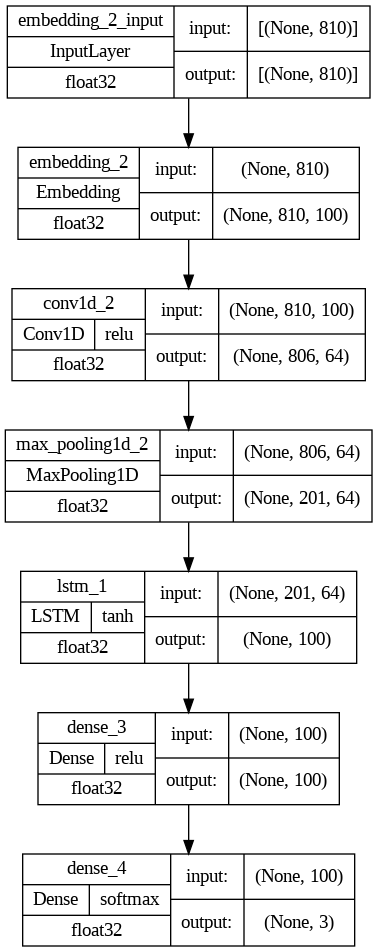

In [ ]:
plot_model(
    CNN_LSTM_Dense,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

In [ ]:
# Train the CNN + Dense model
CNN_LSTM_Dense_history = CNN_LSTM_Dense.fit(train_reviews_padded, y_train, epochs=EPOCHS, validation_data=(valid_reviews_padded, y_valid))

Epoch 1/20
25/25 [==============================] - 9s 207ms/step - loss: 0.9768 - acc: 0.6137 - val_loss: 0.9528 - val_acc: 0.5400
Epoch 2/20
25/25 [==============================] - 5s 211ms/step - loss: 0.8593 - acc: 0.6237 - val_loss: 0.9543 - val_acc: 0.5400
Epoch 3/20
25/25 [==============================] - 3s 138ms/step - loss: 0.8573 - acc: 0.6237 - val_loss: 0.9502 - val_acc: 0.5400
Epoch 4/20
25/25 [==============================] - 3s 121ms/step - loss: 0.8569 - acc: 0.6237 - val_loss: 0.9725 - val_acc: 0.5400
Epoch 5/20
25/25 [==============================] - 2s 80ms/step - loss: 0.8589 - acc: 0.6237 - val_loss: 0.9585 - val_acc: 0.5400
Epoch 6/20
25/25 [==============================] - 3s 128ms/step - loss: 0.8564 - acc: 0.6237 - val_loss: 0.9908 - val_acc: 0.5400
Epoch 7/20
25/25 [==============================] - 3s 122ms/step - loss: 0.8570 - acc: 0.6237 - val_loss: 0.9768 - val_acc: 0.5400
Epoch 8/20
25/25 [==============================] - 2s 58ms/step - loss: 0.85

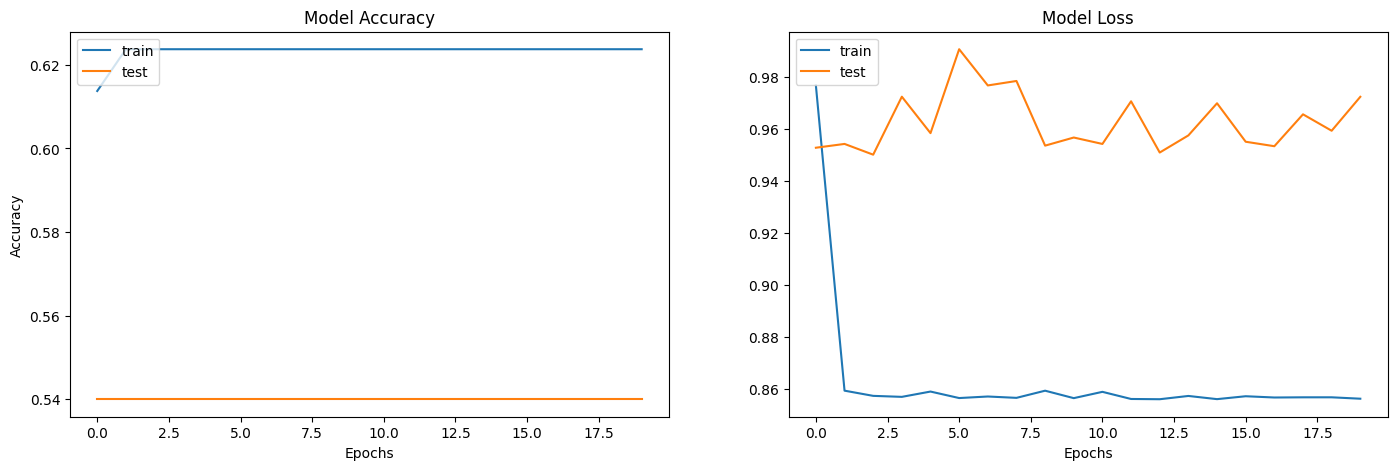

In [ ]:
display_graphs(CNN_LSTM_Dense.history)

In [ ]:
# Define file path to save/load CNN + LSTM + Dense model
filepath_CNN_LSTM_Dense= '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_LSTM_Dense_rating_predictor.keras'

In [ ]:
# save CNN + LSTM + Dense model
keras.saving.save_model(CNN_Dense, filepath_CNN_LSTM_Dense)

# Load Trained Models

**SNN**

In [ ]:
# Define file path to save/load SNN model
filepath_SNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/SNN_rating_predictor.keras'

# load SNN model
SNN = tf.keras.saving.load_model(
    filepath_SNN, custom_objects=None, compile=True
)

OSError: No file or directory found at /content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/SNN_rating_predictor.keras

**CNN**

In [ ]:
# Define file path to save/load CNN model
filepath_CNN = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/CNN_rating_predictor.keras'

# load CNN model
CNN = tf.keras.saving.load_model(
    filepath_CNN, custom_objects=None, compile=True
)

**LSTM**

In [ ]:
# Define file path to save/load LSTM model
filepath_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/Sentiment_Analysis_Project/LSTM_rating_predictor.keras'

# load LSTM model
LSTM = tf.keras.saving.load_model(
    filepath_LSTM, custom_objects=None, compile=True
)

**CNN + LSTM**

In [ ]:
# Define file path to save/load CNN + LSTM model
filepath_CNN_LSTM = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_LSTM_rating_predictor.keras'

# load CNN + LSTM model
CNN_LSTM = tf.keras.saving.load_model(
    filepath_CNN_LSTM, custom_objects=None, compile=True
)

**CNN + Dense**

In [ ]:
# Define file path to save/load CNN + Dense model
filepath_CNN_Dense = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_Dense_rating_predictor.keras'

# load CNN + Dense model
CNN_Dense = tf.keras.saving.load_model(
    filepath_CNN_Dense, custom_objects=None, compile=True
)

**CNN + LSTM + Dense**

In [ ]:
# Define file path to save/load CNN + + LSTM + Dense model
filepath_CNN_LSTM_Dense = '/content/drive/MyDrive/Sheffield_Hallam_University/Final Year/Development Project/development_project_shared/Source_Code/CNN_LSTM_Dense_rating_predictor.keras'

# load CNN + LSTM + Dense model
CNN_LSTM_Dense = tf.keras.saving.load_model(
    filepath_CNN_LSTM_Dense, custom_objects=None, compile=True
)

# Evaluation

In [ ]:
test_reviews_padded = tokenize(test_reviews)

In [ ]:
def score_accuracy(model):
  # Predictions on the Test Set
  score = model.evaluate(test_reviews_padded, y_test, verbose=1)

  # Model Performance
  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])

In [ ]:
score_accuracy(SNN)

In [ ]:
score_accuracy(CNN)

In [ ]:
score_accuracy(LSTM)

In [ ]:
score_accuracy(CNN_LSTM)

In [ ]:
score_accuracy(CNN_Dense)

In [ ]:
score_accuracy(CNN_LSTM_Dense)

**Confusion Matrices**

In [ ]:
# Convert multidimensional y array to a one-dimensional array
def convert_y_to_1D(y):
  return np.argmax(y, axis=1)

In [ ]:
#Create a confusion matrix for a model from the feature space and true labels
def create_confusion_matrix(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Generate matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Normalise confusion matrix rounded to a percentage up to 2 d.p.
  conf_matrix = conf_matrix/ conf_matrix.astype(np.float).sum(axis=1)

  return conf_matrix

In [ ]:
# Display confusion matrix in a seaborn graph
def display_conf_matrix(conf_matrix, ax):

  # Display column with predicted labels
  columns_ = [f'Predicted: {label}' for label in labels]

  # Display X-axis with actual labels
  index_ = [f'Actual: {label}' for label in labels]

  # Convert confusion matrix object to dataframe for display
  conf_matrix_pd = pd.DataFrame(conf_matrix, columns=columns_, index=index_)

  return sns.heatmap(conf_matrix_pd, ax=ax, annot=True, cmap='magma')

In [ ]:
# Create confusion matrix of the training dataset for the SNN model
cm_train_SNN = create_confusion_matrix(SNN, train_reviews_padded, y_train)

# Create confusion matrix of the training dataset for the CNN model
cm_train_CNN = create_confusion_matrix(CNN, train_reviews_padded, y_train)

# Create confusion matrix of the training dataset for the LSTM model
cm_train_LSTM = create_confusion_matrix(LSTM, train_reviews_padded, y_train)

# Create confusion matrix of the validation dataset for the SNN model
cm_valid_SNN = create_confusion_matrix(SNN, valid_reviews_padded, y_valid)

# Create confusion matrix of the validation dataset for the CNN model
cm_valid_CNN = create_confusion_matrix(CNN, valid_reviews_padded, y_valid)

# Create confusion matrix of the validation dataset for the LSTM model
cm_valid_LSTM = create_confusion_matrix(LSTM, valid_reviews_padded, y_valid)

**Confusion Matrices For Training Dataset**

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Training Dataset', fontsize=20)
axes[0].set_title('SNN')
axes[1].set_title('CNN')
axes[2].set_title('LSTM')
display_conf_matrix(cm_train_SNN, axes[0])
display_conf_matrix(cm_train_CNN, axes[1])
display_conf_matrix(cm_train_LSTM, axes[2])
plt.show()

**Confusion Matrices For Validation Dataset**

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,6))
fig.suptitle('Confusion Matrices For Validation Dataset', fontsize=20)
axes[0].set_title('SNN')
axes[1].set_title('CNN')
axes[2].set_title('LSTM')
display_conf_matrix(cm_valid_SNN, axes[0])
display_conf_matrix(cm_valid_CNN, axes[1])
display_conf_matrix(cm_valid_LSTM, axes[2])
plt.show()

**Accuracy, precision, recall and f1 scores**

In [ ]:
#Calculates accuracy, precision, recall, f1 and specificity from predicted and true results
def calc_scores(model, X_fold, y_true):
  # Calculate predicted values
  y_pred = model.predict(X_fold)

  # Convert y_true and y_pred to one-dimensional arrays
  y_true, y_pred = convert_y_to_1D(y_true), convert_y_to_1D(y_pred)

  # Calculate accuracy score
  accuracy = accuracy_score(y_true, y_pred)

  # Calculate precision score
  precision = precision_score(y_true, y_pred, average='weighted')

  # Calculate recall score
  recall = recall_score(y_true, y_pred, average='weighted')

  # Calculate f1 score
  f1 = f1_score(y_true, y_pred, average='weighted')

  return [accuracy, precision, recall, f1]

In [ ]:
#Define the accuracy, precision, recall and f1 scores of each model for the training dataset
scores_train_SNN = calc_scores(SNN, train_reviews_padded, y_train)
scores_train_CNN = calc_scores(CNN, train_reviews_padded, y_train)
scores_train_LSTM = calc_scores(LSTM, train_reviews_padded, y_train)

#Define the accuracy, precision, recall and f1 scores of each model for the validation dataset
scores_valid_SNN = calc_scores(SNN, valid_reviews_padded, y_valid)
scores_valid_CNN = calc_scores(CNN, valid_reviews_padded, y_valid)
scores_valid_LSTM = calc_scores(LSTM, valid_reviews_padded, y_valid)

In [ ]:
def create_scores_dict(model, name):
  scores_train = calc_scores(model, train_reviews_padded, y_train)
  scores_valid = calc_scores(model, valid_reviews_padded, y_valid)
  dict_ = {'Accuracy (Train)' : scores_train[0],
          'Accuracy (Valid)' : scores_valid[0],
            'Precision (Train)' : scores_train[1],
            'Precision (Valid)' : scores_valid[1],
            'Recall (Train)' : scores_train[2],
          'Recall (Valid)' : scores_valid[2],
            'F1 (Train)' : scores_train[3],
            'F1 (Valid)' : scores_valid[3]
            }
  return dict_

In [ ]:
# Define the model names and their scores for both training and validation set
models = {'SNN' : create_scores_dict(SNN, 'SNN'),
          'CNN' : find_scores(CNN, 'CNN'),
          'LSTM' : create_scores_dict(LSTM, 'LSTM'),
          'CNN + LSTM' : find_scores(CNN_LSTM, 'CNN_LSTM'),
          'CNN + Dense' : create_scores_dict(CNN_Dense, 'CNN + Dense'),
          'CNN + LSTM + Dense' : find_scores(CNN_LSTM_Dense, 'CNN + LSTM + Dense'),
                   }
          }
#Create a dataframe table of the dictionary of the models
scores = pd.DataFrame(models).T
scores

# Live Prediction

**Using `X_test`**

In [ ]:
test_reviews_array = np.asarray(test_reviews)

In [ ]:
print(type(test_reviews))

In [ ]:
y_test = convert_y_to_1D(y_test)

In [ ]:
test_data = {'Review': test_reviews, 'Rating': y_test}

test_df = pd.DataFrame(data=test_data)

In [ ]:
def find_pred(model, X_fold):
  pred = model.predict(X_fold)

  pred = np.argmax(pred, axis=1)

  return pred

In [ ]:
print(len(test_reviews_padded))

In [ ]:
# Passing tokenised instance to the SNN model for predictions
SNN_pred = find_pred(SNN, test_reviews_padded)

# Passing tokenised instance to the CNN model for predictions
CNN_pred = find_pred(CNN, test_reviews_padded)

# Passing tokenised instance to the LSTM model for predictions
LSTM_pred = find_pred(LSTM, test_reviews_padded)


In [ ]:
print(SNN_pred)

In [ ]:
test_df['SNN Prediction'] = SNN_pred

test_df['CNN Prediction'] = CNN_pred

test_df['LSTM Prediction'] = LSTM_pred

In [ ]:
test_df

**User Input**

In [ ]:
example = reviews[0]

print(type(example))

In [ ]:
print(len(example))

In [ ]:
input_review = input("Enter review: ")

input_review_processed = preprocess_text(input_review)

input_review_padded = tokenize(input_review_processed)

print(input_review_processed)

print(len(input_review))

In [ ]:
input_review = input("Enter review: ")

input_review_processed = preprocess_text(input_review)

input_review_padded = tokenize(input_review_processed)

SNN_pred = find_pred(SNN, input_review_padded)

CNN_pred = find_pred(CNN, input_review_padded)

LSTM_pred = find_pred(LSTM, input_review_padded)

print("Review: ", input_review)
print("SNN Prediction: ", SNN_pred)
print("CNN Prediction: ", CNN_pred)
print("LSTM Prediction: ", LSTM_pred)

# Django Practice

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip3 install pipenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 22.0 MB/s eta 0:00:00


#